In [1]:
% matplotlib inline
import os
os.chdir('/home/jagust/dino/surf/')
from surf import *

In [2]:
pos_func_mat = np.load('/home/jagust/dino/github/surf/thr_pos_func_mat.npy')
neg_func_mat = np.load('/home/jagust/dino/github/surf/thr_neg_func_mat.npy')

funcnetneg = nx.Graph(neg_func_mat)
funcnetpos = nx.Graph(pos_func_mat)

pibmatneg = np.load('/home/jagust/dino/surf/mats/neg_pib_mat.npy')
pibmatpos = np.load('/home/jagust/dino/surf/mats/pos_pib_mat.npy')

pibnetneg = nx.Graph(pibmatneg)
pibnetpos = nx.Graph(pibmatpos)

In [39]:
neg_results = run_simulation(funcnetneg, pibnetneg, 41, 70, efficiency=False, disconnects=True)
pos_results = run_simulation(funcnetpos, pibnetpos, 55, 70, efficiency=False, disconnects=True)

Return value is a list of list of results - Indices for metrics:
Modularity: 0
Efficiency: 1
Degree : 2
# of disconnected components: 3
Return value is a list of list of results - Indices for metrics:
Modularity: 0
Efficiency: 1
Degree : 2
# of disconnected components: 3


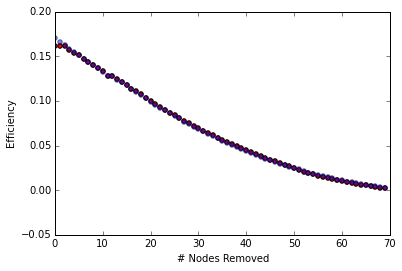

In [56]:
# Plot Efficiencies
fig = plt.figure()
ax = fig.add_subplot(111)


ax.scatter(range(len(neg_results[1])), neg_results[1], c = 'r')
ax.scatter(range(len(pos_results[1])), pos_results[1], c = 'b', alpha = 0.5)

plt.xlim(0, 70)
plt.xlabel('# Nodes Removed')
plt.ylabel('Efficiency')

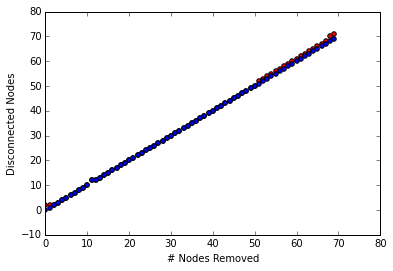

In [52]:
# Plot Disconnected Nodes
fig = plt.figure()
ax = fig.add_subplot(111)


ax.scatter(range(len(neg_results[4])), neg_results[4], c = 'r')
ax.scatter(range(len(pos_results[4])), pos_results[4], c = 'b')

plt.xlim(0, 80)
plt.xlabel('# Nodes Removed')
plt.ylabel('Disconnected Nodes')

In [10]:
def find_next_node(r, g):
    """ Find the next node to be removed in the simulation
    
    Parameters
    ----------
        r : set of removed nodes
        
    Returns
    -------
        node : next node to be removed
    """
    nodes = g.nodes()
    distance = {}
    for node in nodes:
        if node in r:
            continue
        distance[node] = 0.0
        for removed in r:
            distance[node] += nx.shortest_path_length(g, node, removed, 'distance') 
        sorted_distances = sort_by_val(distance)
    return sorted_distances[0][0]

def run_simulation(fnet, pnet, seed, stop, binary = True, efficiency = False, modularity = False, total_degree = False, average_degree = False, disconnects = False):
    ''' Run lesion simulation
    Parameters
    ----------
    fnet : functional network
    pnet : PiB correlation network
    seed : beginning of simulated lesioning
    stop : terminate simulation after removing stop number of nodes
    
    Returns
    -------
    mods : tracks modularity of functional network as nodes are removed
    effs : tracks efficiencies of functional network as nodes are removed
    total_deg : tracks total degree of functional network
    avg_deg : tracks average degree of functional network
    discs : tracks # of disconnected nodes in functional network

    Notes:
        -Partition of functional network is found using Newman Spectral
        -Efficiency is defined as the inverse of the average shortest path length
            of the functional network
    '''

    # Initial global metrics
    mods, effs, tot_deg, avg_deg, discs = [], [], [], [], []
    
    if modularity:
        ind = md.newman_partition(fnet, max_div=np.inf).index
        part = md.GraphPartition(fnet, index=ind)
        mods.append(part.modularity())
    if efficiency:
        effs.append(find_eff(fnet))
    if total_degree:
        if binary:
            tot_deg.append(sum(fnet.degree().values()))
        else:
            tot_deg.append(sum(fnet.degree(weight='weight').values()))
    if average_degree:
        if binary:
            avg_deg.append(np.mean(fnet.degree().values()))
        else:
            avg_deg.append(np.mean(fnet.degree().values()))
    if disconnects:
        discs.append(num_disconnects(fnet))
    
    removed = {seed}
    while len(removed) < stop:
        print len(removed)
        # Remove next node
        rem = find_next_node(removed, pnet)
        removed.add(rem)
        fnet.remove_edges_from(fnet.edges(rem))
        
        # Calculate new metrics
        if modularity:
            mods.append(md.GraphPartition(fnet, index=ind).modularity())
        if efficiency:
            effs.append(find_eff(fnet, binary))
        if total_degree:
            if binary:
                tot_deg.append(sum(fnet.degree().values()))
            else:
                tot_deg.append(sum(fnet.degree(weight='weight').values()))
        if average_degree:
            if binary:
                avg_deg.append(np.mean(fnet.degree().values()))
            else:
                avg_deg.append(np.mean(fnet.degree().values()))
        if disconnects:
            discs.append(num_disconnects(fnet))
    
    print "Return value is a list of list of results - Indices for metrics:"
    print "Modularity: 0"
    print "Efficiency: 1"
    print "Total Degree : 2"
    print "# of disconnected components: 3"

    return [mods, effs, tot_deg, avg_deg, discs]

In [11]:
def find_eff(g, bin = True):
    ''' Finds the efficiency of a network
    Parameters
    ----------
    g : A binary unweighted graph
    
    Returns
    -------
    eff : Efficiency
    
    Notes:
    
    '''
    effs = []
    for node in g.nodes():
        nodal_effs = []
        for target in g.nodes():
            if node == target:
                continue
            else:
#                 try:
                if bin:
                    sp = len(nx.shortest_path(g, node, target))
                else:
                    sp = nx.shortest_path_length(g, node, target, weight='distance')
                nodal_effs.append(1.0 / sp)
#                 except:
#                     print "here"
#                     nodal_effs.append(0.0)
        effs.append(np.mean(nodal_effs))
    return np.mean(effs) / 2.0

def find_eff(g, bin = True):
    ''' Finds the efficiency of a network
    Parameters
    ----------
    g : A binary unweighted graph
    
    Returns
    -------
    eff : Efficiency
    
    Notes:
    
    '''
    effs = []
    for node in g.nodes():
        nodal_effs = []
        for target in g.nodes():
            if node == target:
                continue
            else:
                try:
                    if bin:
                        sp = len(nx.shortest_path(g, node, target))
                    else:
                        sp = nx.shortest_path_length(g, node, target, weight='distance')
                    nodal_effs.append(1.0 / sp)
                except:
                    print "here"
                    nodal_effs.append(0.0)
        effs.append(np.mean(nodal_effs))
    return np.mean(effs) / 2.0


Running Simulation on Weighted Absolute Value Graph
==

In [5]:
def sort_by_val(d):
    ''' Sort a dictionary by value
    
    Parameters
    ----------
    d : a dictionary
    
    Returns
    -------
    l : a list of key-value pairs in tuples 
    '''
    l = sorted(d.items(), key = operator.itemgetter(1))
    return l

In [6]:
pos_func_mat = np.load('/home/jagust/dino/surf/mats/pos_group_mat_med.npy')
neg_func_mat = np.load('/home/jagust/dino/surf/mats/neg_group_mat_med.npy')

pos_func_mat = np.absolute(pos_func_mat)
neg_func_mat = np.absolute(neg_func_mat)

In [7]:
pos_func_net = nx.Graph(pos_func_mat)
neg_func_net = nx.Graph(neg_func_mat)

add_distance_attr(pos_func_net)
add_distance_attr(neg_func_net)

add_distance_attr(pibnetpos)
add_distance_attr(pibnetneg)

In [12]:
pos_results_1 = run_simulation(pos_func_net.copy(), pibnetpos, 55, 80, binary=False, total_degree=True, efficiency=True)
#neg_results_1 = run_simulation(neg_func_net, pibnetneg, 41, 80, binary=False, total_degree=True, efficiency=True)

1


NetworkXNoPath: node 0 not reachable from 66

In [135]:
np.save('/home/jagust/dino/surf/simulation_trials/new_efficiency/geno_pos_results.npy', np.array(pos_results_1[1]))

In [13]:
pos_res = np.load('/home/jagust/dino/surf/simulation_trials/new_efficiency/geno_pos_results.npy')
neg_res = np.load('/home/jagust/dino/surf/simulation_trials/new_efficiency/geno_neg_results.npy')

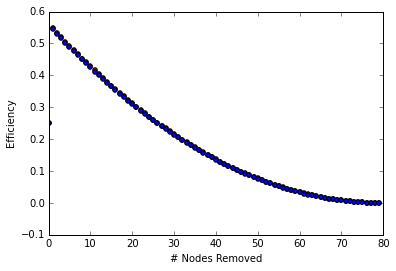

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)


ax.scatter(range(len(neg_res)), neg_res, c = 'r')
ax.scatter(range(len(pos_res)), pos_res, c = 'b')

plt.xlim(0, 80)
plt.xlabel('# Nodes Removed')
plt.ylabel('Efficiency')

In [82]:
# Shortest Path Length == Dijkstra Path Lenght ???
for s in range(80):
    for t in range(80):
        d =  nx.dijkstra_path_length(pos_func_net, s, t, weight='distance')
        sp = nx.shortest_path_length(pos_func_net, s, t, weight='distance')
        if d != sp:
            print s, t